# Set up
## Check Environment

In [11]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [12]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [13]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud

In [31]:
df = pd.read_csv("s3://sagemaker-us-east-1-898900188658/gun_violence_data/gun_violence.csv")
df_agi_by_zip = pd.read_csv("s3://sagemaker-us-east-1-898900188658/income_by_zip/combined_csv-cleaned.csv")
df_inc_zip = pd.read_csv("s3://sagemaker-us-east-1-898900188658/zipcodes/incident_zips.csv")

## Most Frequent Gun Used Was 'Handgun'. Significant portion of the dataset had record with gun type not recorded or known.

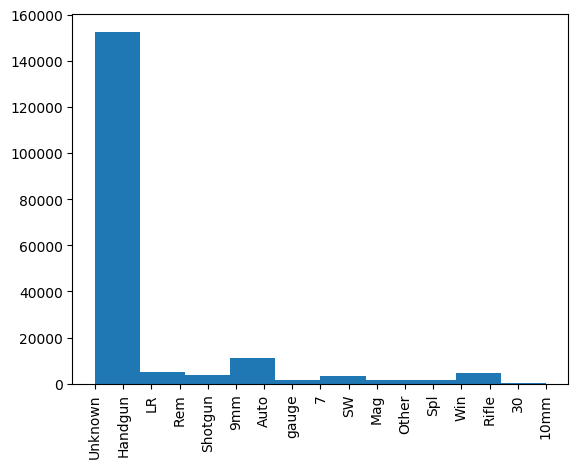

In [32]:
"""
Parse gun_type column and display histogram of gun type frequency

"""
import re
import math

guns_list = []

for item in df['gun_type']:

    if type(item) == float and math.isnan(item):
        continue

    gun = re.findall("\d*::\d* (?P<gun>\w*)", item)

    if len(gun) == 0:
        gun = re.findall("\d*::(?P<gun>\w*)", item)

    guns_list.extend(gun)

# print(guns_list)

plt.xticks(rotation="vertical")
plt.hist(guns_list)
plt.show()

## Out Of All Gun Violence Incidents Recorded, There Are In Total More Suspects Than Victims

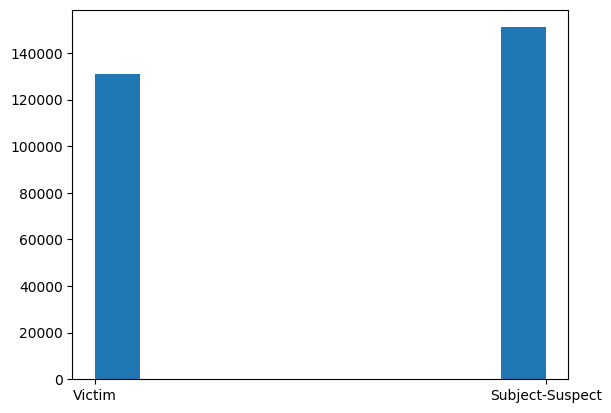

In [33]:
participant_type = df['participant_type']
cleaned = []

for parts in participant_type:

    if '||' in str(parts):
        part = str(parts).split('||')
        
        for keyval in part:
            if '::' in str(keyval):
                
                part_value = str(keyval).split('::')
                cleaned.append(part_value[1])

plt.hist(cleaned)
plt.show()

## Suspect Age Group

Most Suspects Belong To 'Adult 18+' Age Group, A Slightly Larger Portion Had No Age Group Recorded For Suspect

              118175
Adult 18+     112493
Teen 12-17      8494
Child 0-11       515
Name: suspect_age, dtype: int64


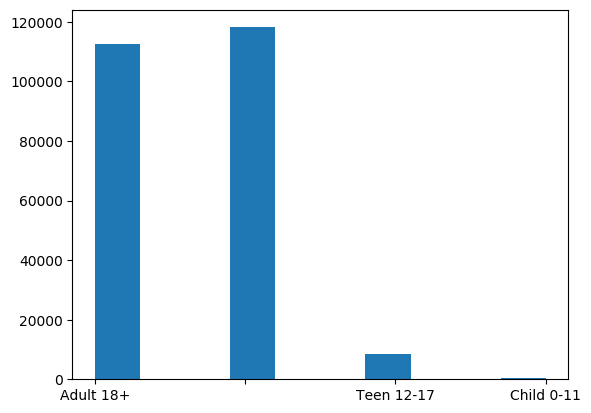

In [34]:
"""
New Suspect Age Group Column
Most suspects are adults 18+ category which doesn't tell us much, so the next column to create
is the actual age of the suspect (see next block in this notebook)
"""
import pandas as pd
import re
import math
import matplotlib.pyplot as plt

df['suspect_age'] = ''

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age_group']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        df.at[i, 'suspect_age'] = element[0]
                    else:
                        df.at[i, 'suspect_age'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


print(df['suspect_age'].value_counts())
plt.clf()
plt.hist(df['suspect_age'])
plt.show()

## Suspect Age

Significant Proportion Of Suspect Age Fell In 25-35 Age Range With The Ages Skewing Towards Younger Ages

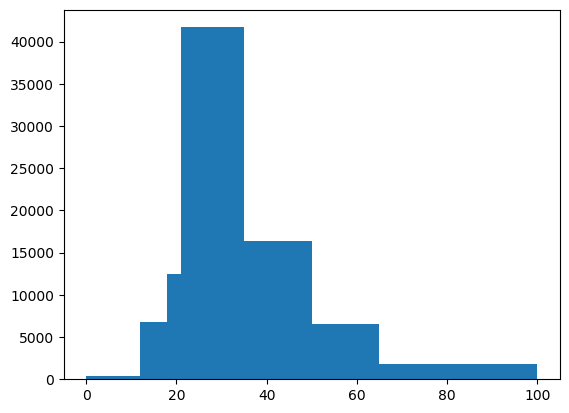

In [35]:
""""
Parse 'participant_type' and 'participant_age' column to get the suspect's actual age
"""
df['suspect_age_value'] = ''
df[['suspect_age_value']] = df[['suspect_age_value']].apply(pd.to_numeric)

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            pass
                            #print("empty element: --%s--" % element[0])
                        else:
                            df.at[i, 'suspect_age_value'] = int(element[0])
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            df.at[i, 'suspect_age_value'] = int(match_age[0])
                        #print("i = %d" % i)
                else:
                    continue


#print(df['suspect_age_value'].value_counts())
plt.clf()
#df = df.dropna(subset=['suspect_age_value'])
#print(type(df_temp.iloc[0]['suspect_age_value']))
#df_temp['suspect_age_value'] = df_temp['suspect_age_value'].apply(int)
#print("dataframe size: %d" % len(df))
plt.hist(df['suspect_age_value'], bins=[0,12,18,21,35,50,65,100])
plt.show()

## Suspect Gender

Overwhelming Majority of Suspects Were Male

size of dataframe at start: 239677


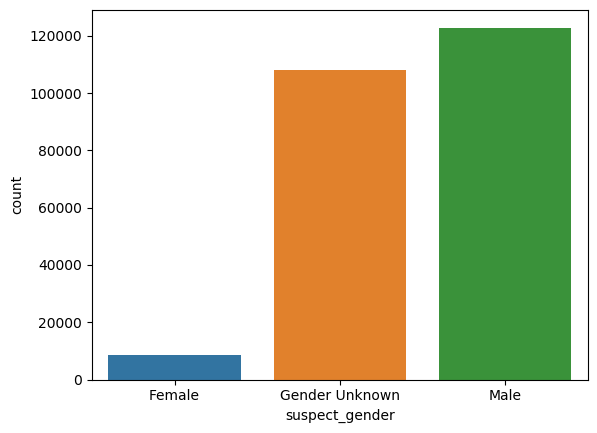

In [36]:
"""
'Gender Unknown' can mean two things:
1: There was a suspect but the gender was not recorded in the dataset
2: There was no suspect in the incident
"""

def has_numbers(inputString):
    if inputString != 'Male' and inputString != 'Female':
        #print("stop here")
        pass

    #print(type(inputString))
    for char in inputString:
        result = char.isdigit()
        if(result == True):
            return result
    #return any(char.isdigit() for char in inputString)
    
print("size of dataframe at start: %d" % len(df))

df['suspect_gender'] = ''
df[['suspect_gender']] = df[['suspect_gender']].apply(str)
# 0 = male
# 1 = female

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_gender row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_gender']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        else:
                            if has_numbers(element[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = element[0]
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            if has_numbers(match_age[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


#print(df['suspect_gender'].value_counts())
plt.clf()
#print("number of rows before dropna(): %d" % len(df))
df_temp = df.dropna(subset=['suspect_gender'])
#print("number of rows after dropna(): %d" % len(df_temp))
#df_temp['suspect_gender'] = df['suspect_gender'].replace('0', 'Unknown')

for i,row in df_temp.iterrows():
    result = row['suspect_gender']
    if result != 'Female' and result != 'Male':
        df_temp.at[i, 'suspect_gender'] = 'Gender Unknown'
    #print(result)

import seaborn as sns

df = df_temp.copy()

sns.countplot(x = df['suspect_gender'], data = df)
plt.show()

## Incident Characteristics

Most Frequent Incident Characteristics For Incidents With 1 or more Injured or Killed

<Figure size 640x480 with 0 Axes>

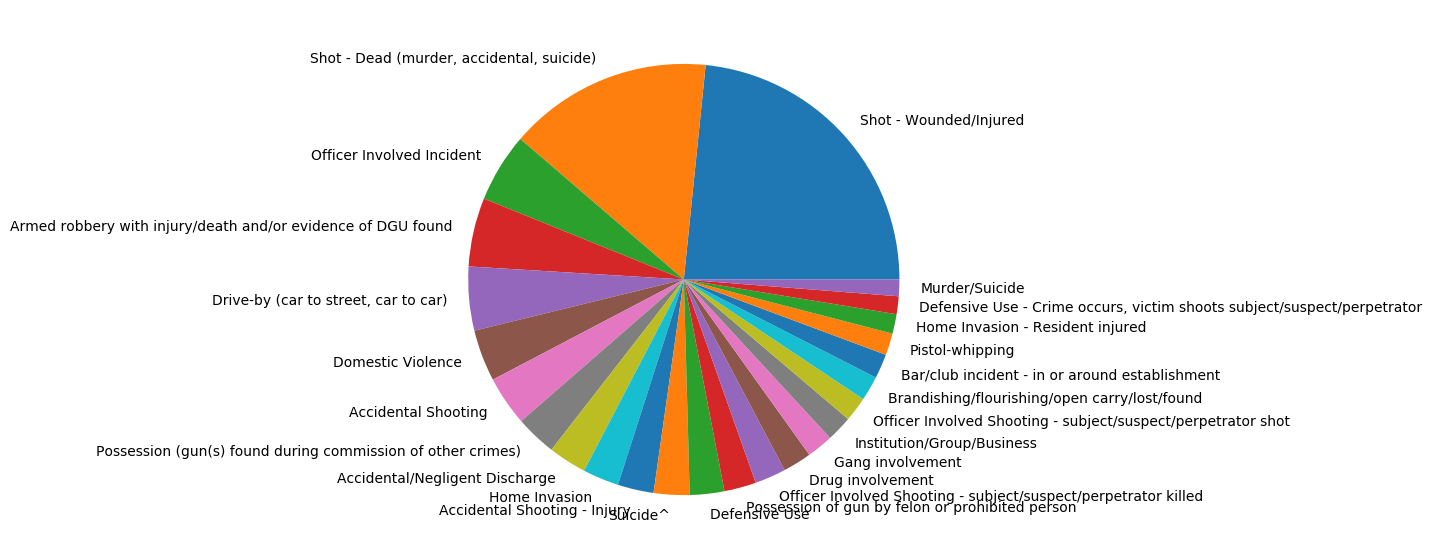

In [37]:
from collections import Counter

phrases_list = []
count = 0

for i, row in df.iterrows():

    if (row['n_injured'] >= 1 or row['n_killed'] >= 1):
        count = count + 1

        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']

            if '||' in str(incident_text):
                item = str(incident_text).split('||')

                for phrases in item:
                    phrases_list.append(phrases)

most_common_words_20 = Counter(phrases_list).most_common(25)
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c / len(counts))

plt.clf()
fig = plt.figure(figsize=(10, 7))
plt.pie(temp, labels=words)
plt.show()


Most Frequent Incident Characteristics Recorded for Gun Violence Incidents Where 0 People Were Injured And 0 People Were Killed

Number of incidents where injured = 0 and killed = 0: 97287
Total rows in dataframe: 239677
Percentage of none injured and none killed: 0.405909


<Figure size 640x480 with 0 Axes>

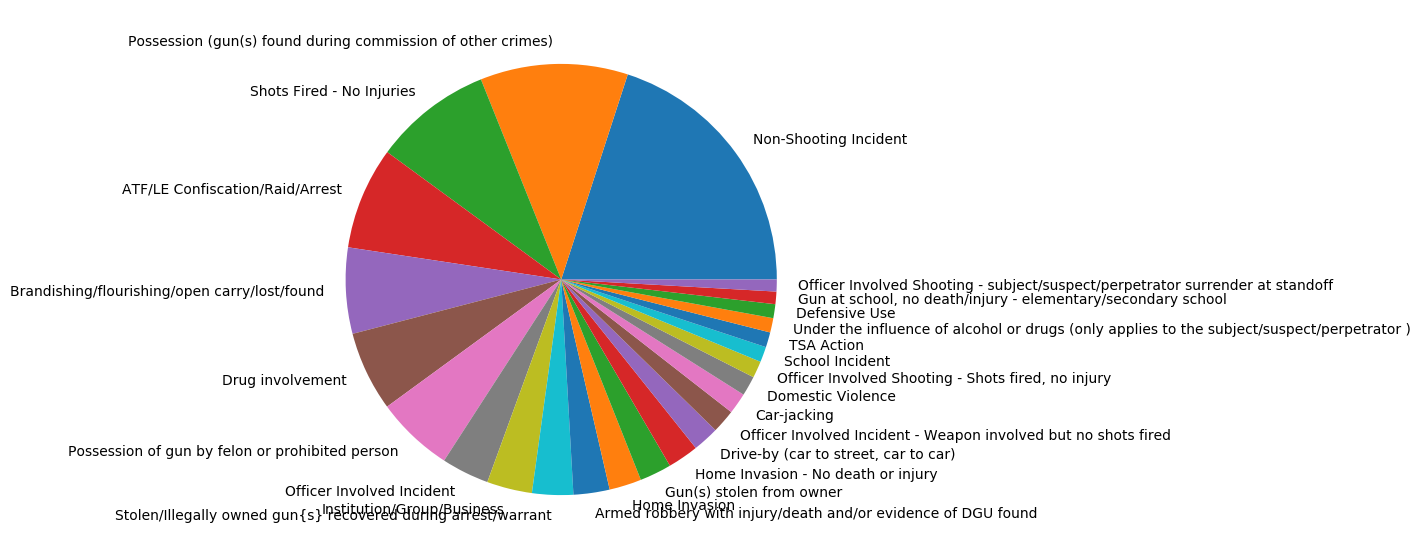

In [38]:
phrases_list = []
count = 0

for i, row in df.iterrows():
    if (row['n_injured'] == 0 and row['n_killed'] == 0):
        count = count + 1
        #print(row['incident_characteristics'])
 
        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']
            
            if '||' in str(incident_text):
                item = str(incident_text).split('||')
                
                for phrases in item:
                    phrases_list.append(phrases)


print("Number of incidents where injured = 0 and killed = 0: %d" % count)
print("Total rows in dataframe: %d" % len(df))
print("Percentage of none injured and none killed: %f" % (count/len(df)))


most_common_words_20 = Counter(phrases_list).most_common(25)
#print("\n\n25 Most Common Phrases in Incident Characteristics column:")
#for word, count in most_common_words_20:
#    print(f"{word}: {count}")

# Represent 20 Most Common Incident Characteristics as Pie Chart
# This is for the incidents where no one was injured or killed
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c/len(counts))
    
plt.clf()
fig = plt.figure(figsize =(10, 7))
plt.pie(temp, labels = words)
plt.show()

## Consistently High Percentage of Injuries or Deaths Associated With Certain Types Participant Relationships

In [ ]:
import seaborn as sns

df['suspect_rel'] = ''

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)

    # get index number of suspect
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_relationship']
            if isinstance(row['participant_relationship'], float):
                pass
            else:
                regex = part_index + '::(.*)'
                #print("regex: %s" % regex)
                #print("temp_age_group: %s" % temp_age_group)
                if not isinstance(temp_age_group, float):
                    match_age = re.findall(regex, temp_age_group)
                    #print("match_age: %s" % match_age)
                    if len(match_age) != 0:
                        if '||' in match_age[0]:
                            element = match_age[0].split('||')
                            if element[0] == '':
                                pass
                                #print("empty element: --%s--" % element[0])
                            else:
                                df.at[i, 'suspect_rel'] = element[0]
                        else:
                            if match_age[0] == '':
                                #print("do nothing")
                                pass
                            else:
                                df.at[i, 'suspect_rel'] = match_age[0]
                            #print("i = %d" % i)
                    else:
                        continue

df_temp = df.dropna()
sns.countplot(x=df_temp['suspect_rel'], data =df_temp)
plt.xticks(rotation=90)
plt.show()

In [23]:
"""
For each type of relationship, get the percentage of incidents that resulted in 1 or more injuries or deaths
"""
rel_types = df_temp['suspect_rel'].value_counts().index

for i in rel_types:
    z = str(i)
    df_rel = df_temp.loc[df_temp['suspect_rel']==z]['n_injured']
    total = len(df_rel)

    df_rel_type = df_temp.loc[(df_temp['suspect_rel']==z) & ((df_temp['n_injured']>0) | (df_temp['n_killed']>0))]
    print("%s: %f" % (z,len(df_rel_type)/total))

Armed Robbery: 0.849275
Significant others - current or former: 0.878924
Family: 0.915385
Aquaintance: 0.914634
Friends: 1.000000
Co-worker: 0.842105
Neighbor: 0.645161
Gang vs Gang: 0.793103
Home Invasion - Perp Knows Victim: 1.000000
Mass shooting - Perp Knows Victims: 1.000000
Home Invasion - Perp Does Not Know Victim: 1.000000
Mass shooting - Random victims: 1.000000


## Incidents Per Adjusted Gross Income Level By ZipCode Overwhelmingly Skews To Lower Income Brackets

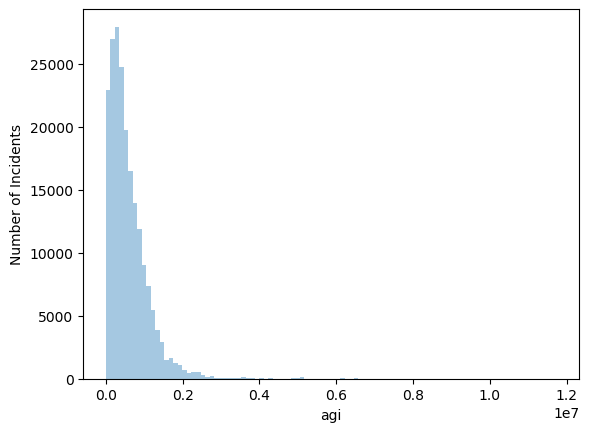

In [29]:
df_merged = df_inc_zip.merge(df_agi_by_zip,on='zipcode')
df_merged = df_merged[['incident_id', 'zipcode', 'agi', 'avg_agi', 'avg_income']]
df = df.merge(df_merged, on='incident_id')

plt.xlabel('Adjusted Gross Income By Zipcode (AGI)')
plt.ylabel('Number of Incidents')
sns.distplot(df['agi'],bins=100,kde=False)
plt.show()